# Test Factor Models VaR and ES
This notebook demonstrates how to use:
- A single-factor model Value-at-Risk (VaR) and Expected Shortfall (ES)
- A Fama-French 3-factor model for VaR and ES

It uses historical return data and factor models to estimate portfolio risk.

In [3]:
import data_download as dd
import factor_models as fm
import pandas as pd
import plots
import backtesting as bt

##  Download data and form a portfolio

In [5]:
# Define shares directly (tickers inferred from index)
shares = pd.Series({
    "AAPL": 10,
    "MSFT": 9,
    "NVDA": 80,
    "GOOGL": 6,
    "JPM": -9
})

# Download prices for the tickers in 'shares'
tickers = shares.index.tolist()
prices = dd.get_raw_prices(tickers, start="2024-01-01")

# Convert prices to base currency (e.g. CHF)
prices_converted = dd.convert_to_base(prices, base_currency="CHF")

# Create portfolio with monetary positions
position_values = dd.create_portfolio(prices_converted, shares)

# Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.summary_statistics(position_values)

# Compute asset weights (based on latest available prices)
latest_prices = prices_converted.iloc[-1]
portfolio_value = (shares * latest_prices).sum()
weights = (shares * latest_prices) / portfolio_value

# Display
final_value = position_values.sum(axis=1).iloc[-1]
print(f"\nPortfolio final value in CHF: {final_value:.2f}")
print("\nSample of daily returns:\n", returns.head())
print("\nMean returns (daily, in CHF):\n", mean_returns)
print("\nCovariance matrix (in CHF):\n", covariance_matrix)


[currency detection] AAPL: USD
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] MSFT: USD
[currency detection] NVDA: USD
[fx download] Downloading FX pairs: CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X

Portfolio final value in CHF: 13098.64

Sample of daily returns:
                 AAPL     GOOGL       JPM      MSFT      NVDA
Date                                                        
2024-01-03  0.002215  0.015257  0.005375  0.009041 -0.002782
2024-01-04 -0.014117 -0.019621  0.005192 -0.008602  0.007571
2024-01-05 -0.002722 -0.003550  0.006319  0.000779  0.024222
2024-01-08  0.025054  0.023792 -0.000594  0.019746  0.065195
2024-01-09 -0.005582  0.011820 -0.011206 -0.000401  0.013592

Mean returns (daily, in CHF):
 AAPL     0.000532
GOOGL    0.000740
JPM      0.001478
MSFT     0

In [6]:
print(weights)

AAPL     0.133163
GOOGL    0.063733
JPM     -0.152050
MSFT     0.263406
NVDA     0.691748
dtype: float64


In [7]:
portfolio_value

13098.644842167367

## Single-Factor VaR and ES

The Single-Factor model assumes that all asset returns are driven by a single common factor — typically the market index.  
This is also referred to as the **Sharpe Single-Index Model**, and is a special case of the delta-normal method.

Each asset’s return is modeled as:

$$
R_i = \alpha_i + \beta_i R_m + \varepsilon_i
$$

where:
- $R_m$ is the market return
- $\beta_i$ is the sensitivity of asset $i$ to the market
- $\varepsilon_i$ is the idiosyncratic (asset-specific) risk

The total variance of asset $i$ is:

$$
\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\varepsilon_i}^2
$$

The portfolio’s covariance matrix is approximated as:

$$
\Sigma = \beta \beta^T \cdot \sigma_m^2 + D
$$

where:
- $\beta$: vector of asset betas
- $\sigma_m^2$: variance of the market return
- $D$: diagonal matrix of idiosyncratic variances

Finally, the portfolio VaR at confidence level $\alpha$ is given by:

$$
\text{VaR}_{\alpha} = z_\alpha \cdot \sigma_p \cdot \text{PortfolioValue}
$$

and the Expected Shortfall (ES) is:

$$
\text{ES}_{\alpha} = \frac{\phi(z_\alpha)}{1 - \alpha} \cdot \sigma_p \cdot \text{PortfolioValue}
$$

where $z_\alpha$ is the quantile of the standard normal distribution and $\phi$ is the standard normal PDF.


In [8]:
# download SP prices
sp = dd.get_raw_prices(["^GSPC"], start="2024-01-01")

# compute benchmark returns
benchmark = sp["^GSPC"].pct_change().dropna()

# align benchmark with asset returns
benchmark = benchmark.reindex(returns.index).ffill()

In [9]:
results_df, portfolio_volatility = fm.single_factor_var(
    returns=returns,
    benchmark=benchmark,
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)


In [10]:
results_df.head(-5)   

,Returns,Benchmark,VaR,VaR Violation,VaR_monetary
Date,,,,,
2024-01-03,0.000907,-0.008016,0.067303,False,881.575826
2024-01-04,-0.000949,-0.003428,0.067303,False,881.575826
2024-01-05,0.015411,0.001826,0.067303,False,881.575826
2024-01-08,0.055243,0.014115,0.067303,False,881.575826
2024-01-09,0.011011,-0.001478,0.067303,False,881.575826
...,...,...,...,...,...
2025-05-06,-0.004867,-0.007693,0.067303,False,881.575826
2025-05-07,0.019985,0.004346,0.067303,False,881.575826
2025-05-08,0.002293,0.005800,0.067303,False,881.575826



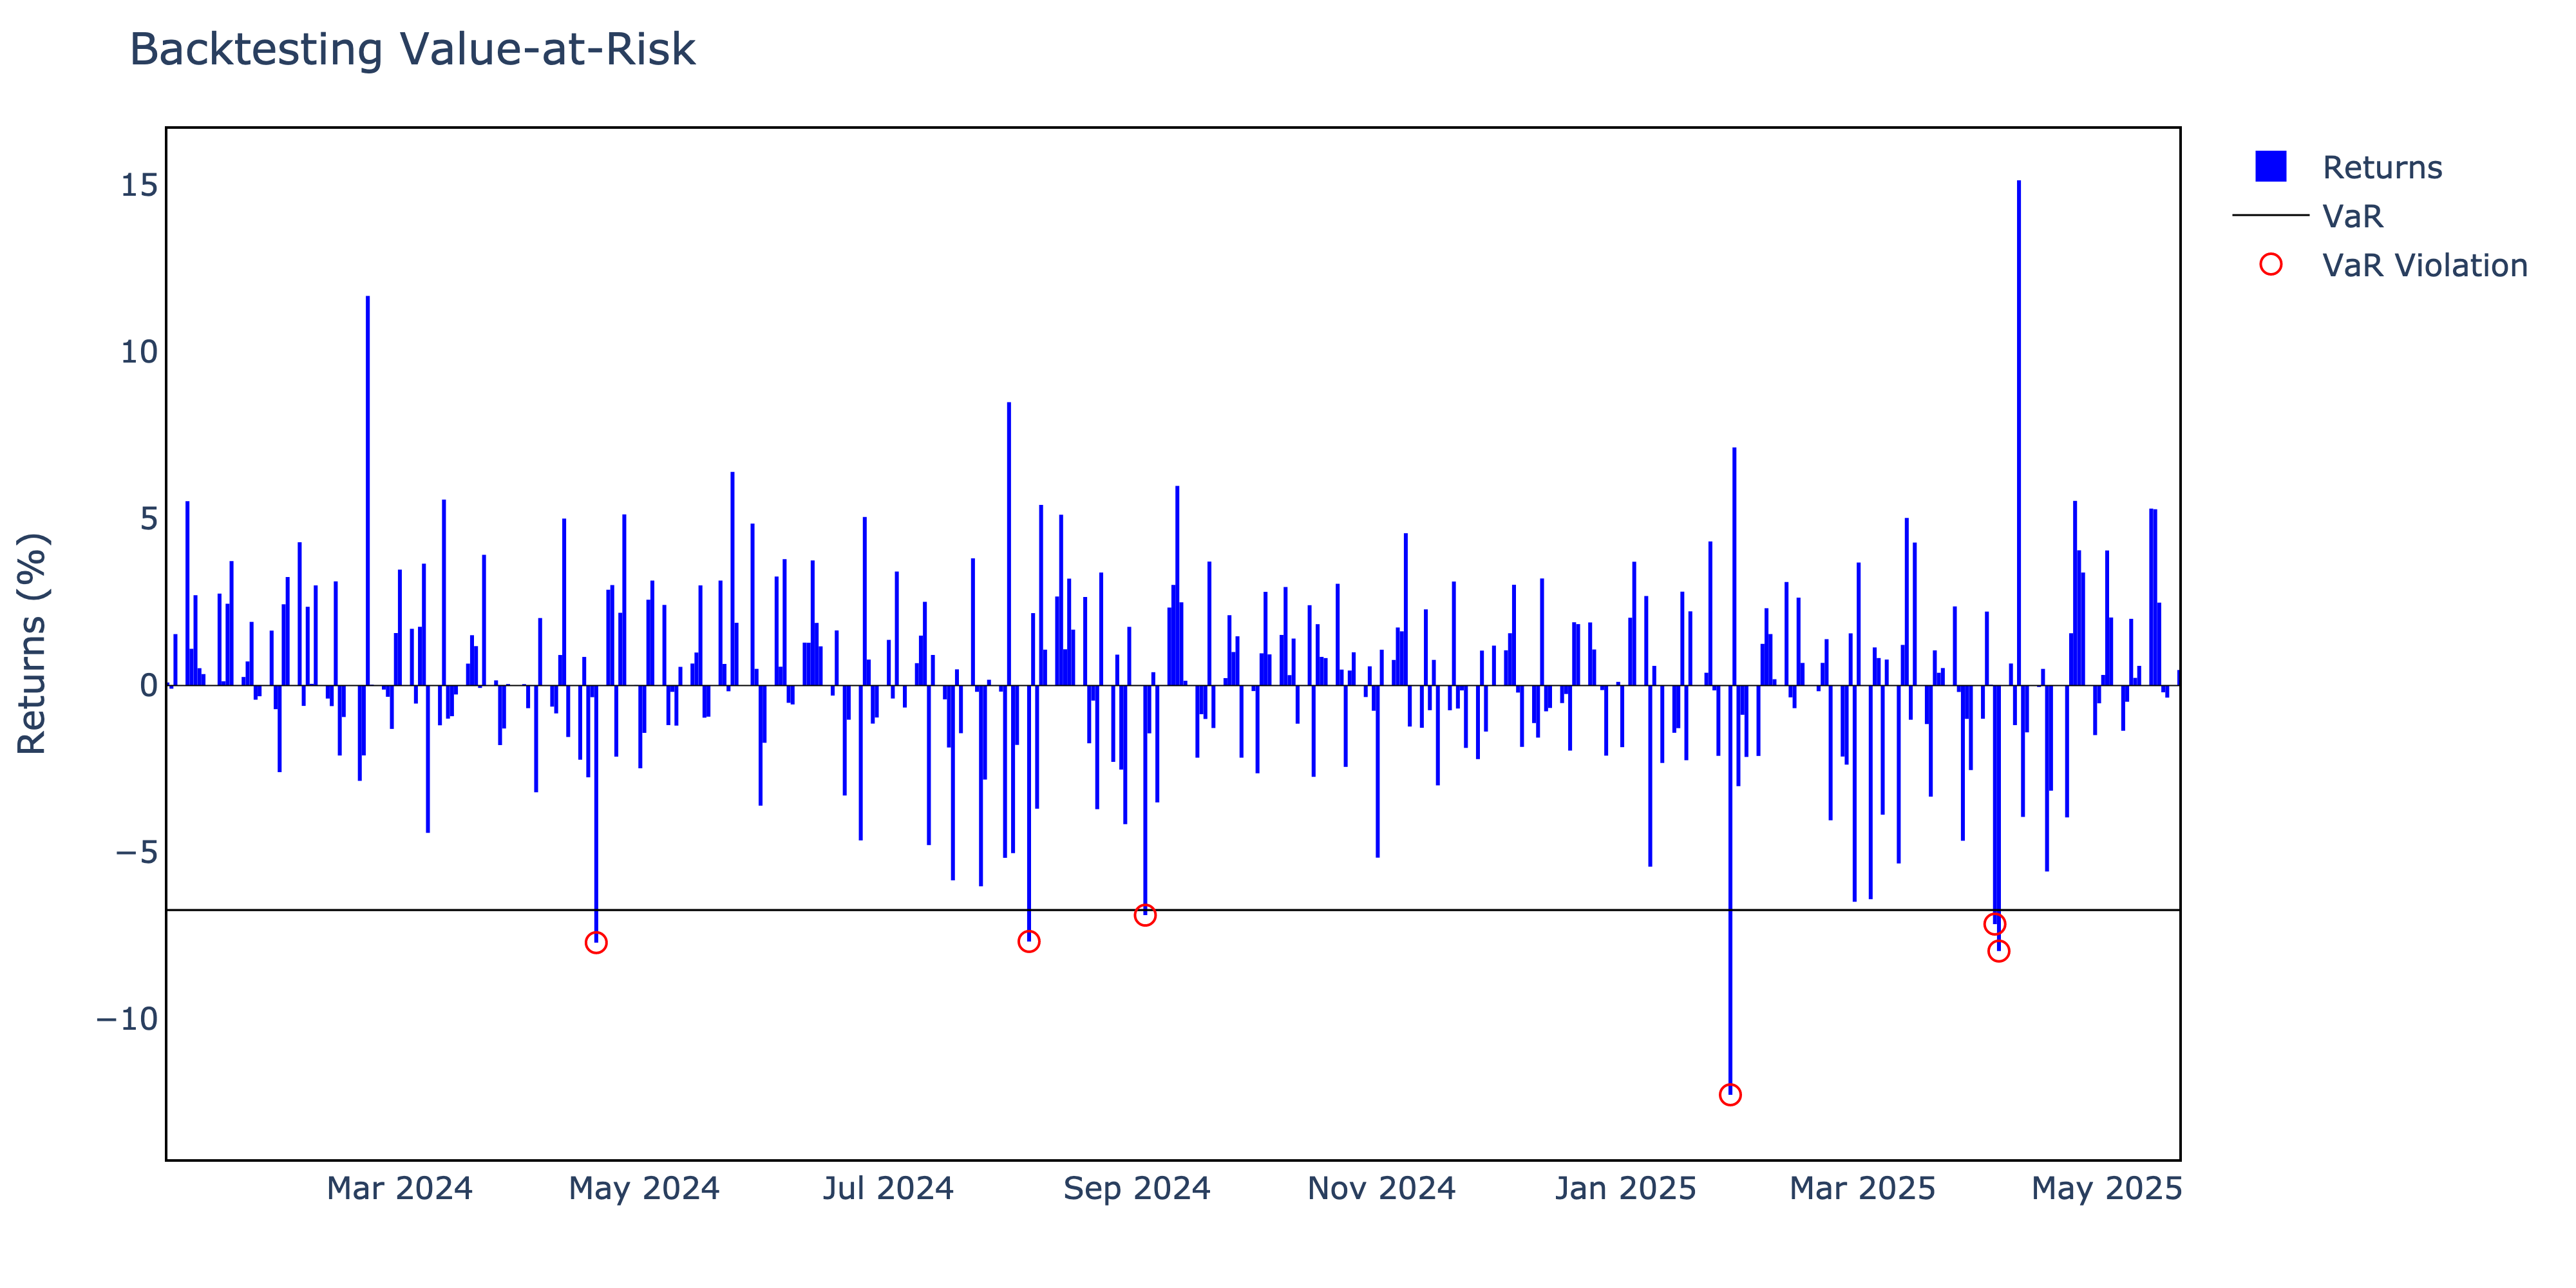

In [11]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [12]:
results_df = fm.factor_models_es(
    result_data= results_df,
    portfolio_volatility=portfolio_volatility,
    confidence_level = 0.99
)

In [13]:
results_df.head(-5)

,Returns,Benchmark,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,
2024-01-03,0.000907,-0.008016,0.067303,False,881.575826,0.077106,1009.990146
2024-01-04,-0.000949,-0.003428,0.067303,False,881.575826,0.077106,1009.990146
2024-01-05,0.015411,0.001826,0.067303,False,881.575826,0.077106,1009.990146
2024-01-08,0.055243,0.014115,0.067303,False,881.575826,0.077106,1009.990146
2024-01-09,0.011011,-0.001478,0.067303,False,881.575826,0.077106,1009.990146
...,...,...,...,...,...,...,...
2025-05-06,-0.004867,-0.007693,0.067303,False,881.575826,0.077106,1009.990146
2025-05-07,0.019985,0.004346,0.067303,False,881.575826,0.077106,1009.990146
2025-05-08,0.002293,0.005800,0.067303,False,881.575826,0.077106,1009.990146



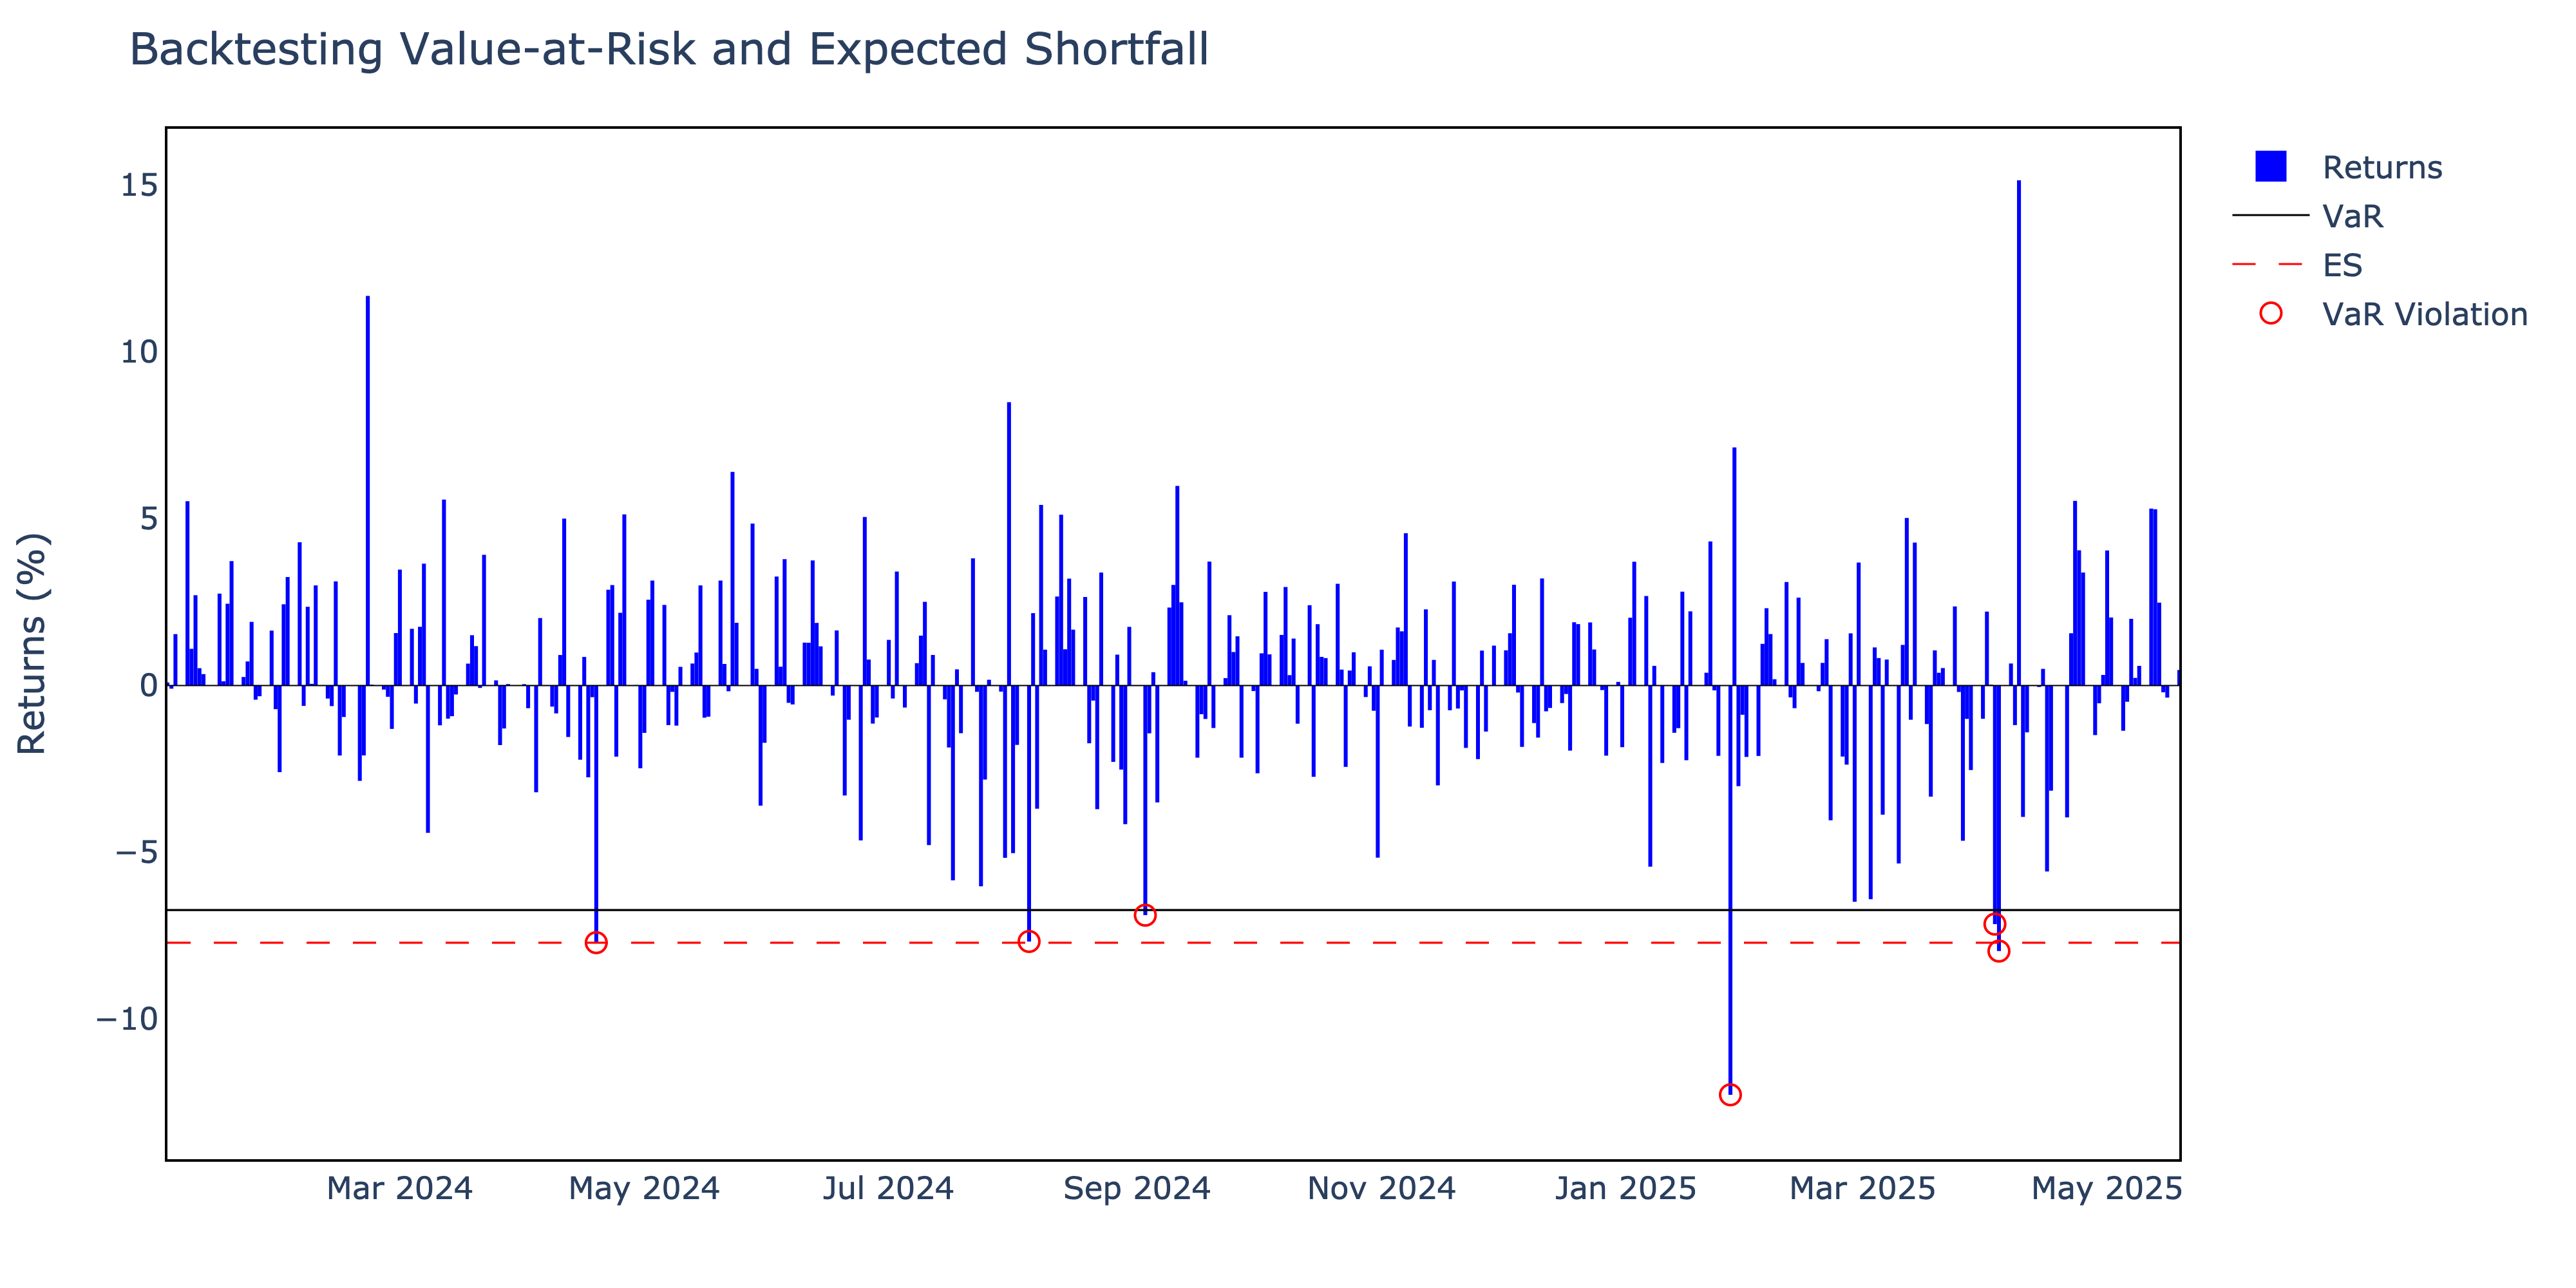

In [14]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [15]:
violations, violation_rate = bt.count_violations(results_df)

violations, violation_rate

(6, 0.017391304347826087)

## Fama-French 3-Factor VaR and ES

The Fama–French 3-factor model extends the CAPM by modeling asset returns using three sources of systematic risk:

- **Mkt_RF**: excess return of the market over the risk-free rate  
- **SMB** ("Small Minus Big"): return of small-cap stocks minus large-cap  
- **HML** ("High Minus Low"): return of high book-to-market stocks minus low  

Each asset’s excess return is regressed on these three factors to estimate its **exposures (betas)**. The model assumes:

$$
R_i - R_f = \alpha_i + \beta_{i1} \cdot \text{Mkt}_{RF} + \beta_{i2} \cdot \text{SMB} + \beta_{i3} \cdot \text{HML} + \varepsilon_i
$$

The estimated covariance matrix of asset returns is reconstructed as:

$$
\Sigma = B \cdot \Sigma_f \cdot B^T + D
$$

Where:
- $B$: matrix of asset betas  
- $\Sigma_f$: covariance matrix of factor returns  
- $D$: diagonal matrix of idiosyncratic variances  

The next code block performs the following steps:

1. Downloads the FF3 daily factor data from Ken French's database.
2. Computes **excess returns** for each asset over the risk-free rate.
3. Regresses each asset’s excess return on the three factors to obtain:
   - **Beta coefficients** (exposures to Mkt_RF, SMB, HML)
   - **Idiosyncratic variance** (residual risk)
4. Builds the **full covariance matrix** of asset returns using the factor structure.
5. Computes **portfolio volatility** using the covariance matrix and current weights.
6. Calculates:
   - **Value-at-Risk (VaR)** at the given confidence level
   - **Conditional VaR (CVaR)**, i.e. expected loss beyond the VaR threshold

The printed outputs show all key components estimated during this process.

In [16]:
# # Download FF3 daily factors and restrict to portfolio date range
# ff_factors = fm.load_ff3_factors(start=returns.index[0], end=returns.index[-1])

# # Check first few rows
# ff_factors.head()

In [17]:
new_df, portfolio_volatility_new = fm.fama_french_var(
    returns=returns, 
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)

new_df.head(-5)

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary
Date,,,,,,,
2024-01-03,0.000907,-0.0101,-0.0194,-0.0014,0.063748,False,835.01511
2024-01-04,-0.000949,-0.0033,0.0021,0.0009,0.063748,False,835.01511
2024-01-05,0.015411,0.0015,-0.0081,0.0065,0.063748,False,835.01511
2024-01-08,0.055243,0.0149,0.0091,-0.0131,0.063748,False,835.01511
2024-01-09,0.011011,-0.0021,-0.0043,-0.0090,0.063748,False,835.01511
...,...,...,...,...,...,...,...
2025-05-06,-0.004867,-0.0046,0.0000,0.0071,0.063748,False,835.01511
2025-05-07,0.019985,-0.0046,0.0000,0.0071,0.063748,False,835.01511
2025-05-08,0.002293,-0.0046,0.0000,0.0071,0.063748,False,835.01511


In [18]:
results_df_new = fm.factor_models_es(
    result_data= new_df,
    portfolio_volatility=portfolio_volatility_new,
    confidence_level = 0.99
)

results_df_new.head(-5)   

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,,,
2024-01-03,0.000907,-0.0101,-0.0194,-0.0014,0.063748,False,835.01511,0.073034,956.647186
2024-01-04,-0.000949,-0.0033,0.0021,0.0009,0.063748,False,835.01511,0.073034,956.647186
2024-01-05,0.015411,0.0015,-0.0081,0.0065,0.063748,False,835.01511,0.073034,956.647186
2024-01-08,0.055243,0.0149,0.0091,-0.0131,0.063748,False,835.01511,0.073034,956.647186
2024-01-09,0.011011,-0.0021,-0.0043,-0.0090,0.063748,False,835.01511,0.073034,956.647186
...,...,...,...,...,...,...,...,...,...
2025-05-06,-0.004867,-0.0046,0.0000,0.0071,0.063748,False,835.01511,0.073034,956.647186
2025-05-07,0.019985,-0.0046,0.0000,0.0071,0.063748,False,835.01511,0.073034,956.647186
2025-05-08,0.002293,-0.0046,0.0000,0.0071,0.063748,False,835.01511,0.073034,956.647186



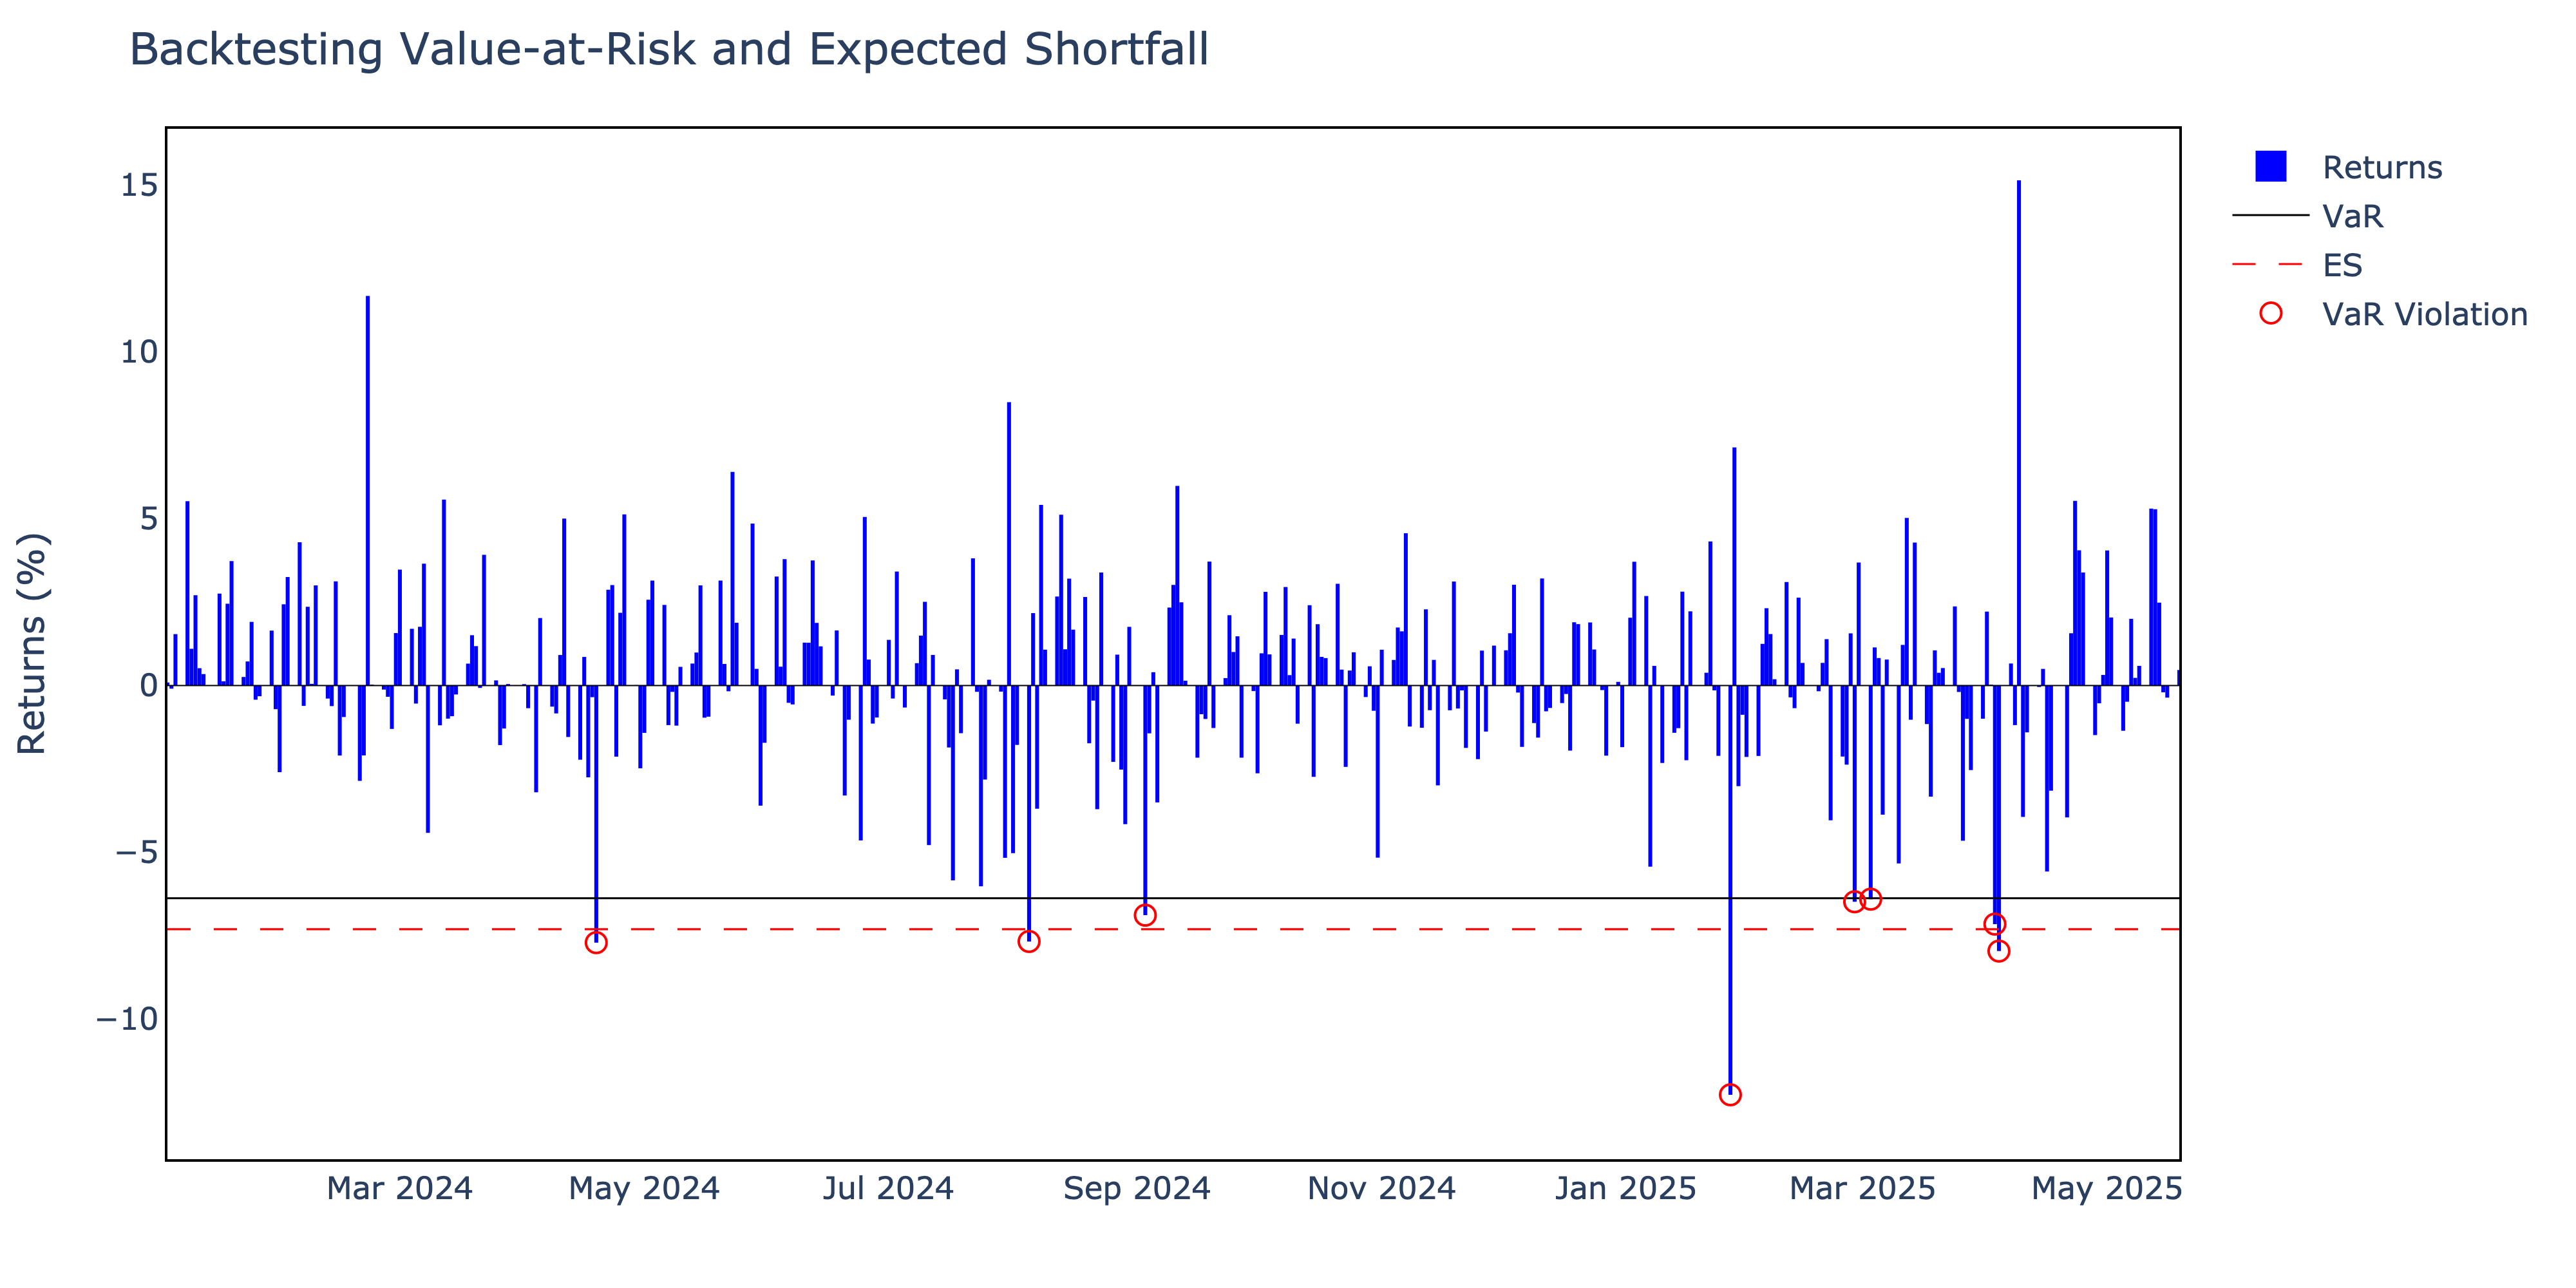

In [19]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df_new, interactive=False)

In [20]:
violations_new, violation_rate_new = bt.count_violations(results_df_new)

violations_new, violation_rate_new

(8, 0.02318840579710145)